# Anomaly Detection on Washer Data Set Using VAE.

# VAE Modelを用いたWasherデータセットの異常検知。

# Import Necessary packages.

# 必要なパッケージをインポートします。

In [1]:
import os
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Input, Flatten 
from tensorflow.keras.layers import Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from IPython.display import Image, display

# Define Data Directory.

# データディレクトリの定義。

In [2]:
washer_ok_img = os.listdir("washer/washer_ok")
washer_ng_img = os.listdir("washer/washer_ng/kizu")
washer_test_img = os.listdir("washer/washer_ng/sabi")

# Set Up Training Data Path.

# トレーニングデータのパスを設定します。

In [3]:
train_path = []
for  ok_img in washer_ok_img[:30] :
    train_path.append('washer/washer_ok/'+ok_img)
    #valid_path.append('washer/washer_ng/kizu/'+ng_img)

print(len(train_path))

30


# Set Up Validation Data Path.

# バリデーションデータのパスを設定します。

In [4]:
valid_path = []
for ng_img in washer_ng_img[:10]:
    valid_path.append('washer/washer_ng/kizu/'+ng_img)
    
print(len(valid_path))

10


# Set Up Test Data Path.

# テストデータのパスの設定します。

In [5]:
test_path = []

for test_img in washer_test_img:
    test_path.append('washer/washer_ng/sabi/'+test_img)

print(len(test_path))

4


# Prepare Sequence Class to Load and Vectorize Batches of Data.

# データのバッチをロードしてベクター化するためのシーケンスクラスを用意すします。

In [6]:
class Washer(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        #pass
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Return input correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

# Define: Image Size, Batch Size, Number of Classes, Number of Channels and Latent Space Dimension.

# 定義します: 画像サイズ、バッチサイズ、クラスの数、チャンネルの数、潜在空間の次元を定義します。


In [7]:
img_size = (128, 128)
#  64,64
# 128,128
batch_size = 1
num_classes = 2
num_channels = 3
latent_space_dim = 4

# Implementation of Encoder.

# エンコーダの実装。

In [8]:
inputs = Input(shape=img_size + (3,))
encoder_conv_layer1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(inputs)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = Flatten()(encoder_activ_layer5)

encoder_mu = Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = Model(inputs, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = Model(inputs, encoder_output, name="encoder_model")

In [9]:
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 128, 128, 1)  28          input_1[0][0]                    
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 128, 128, 1)  4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 128, 128, 1)  0           encoder_norm_1[0][0]             
______________________________________________________________________________________

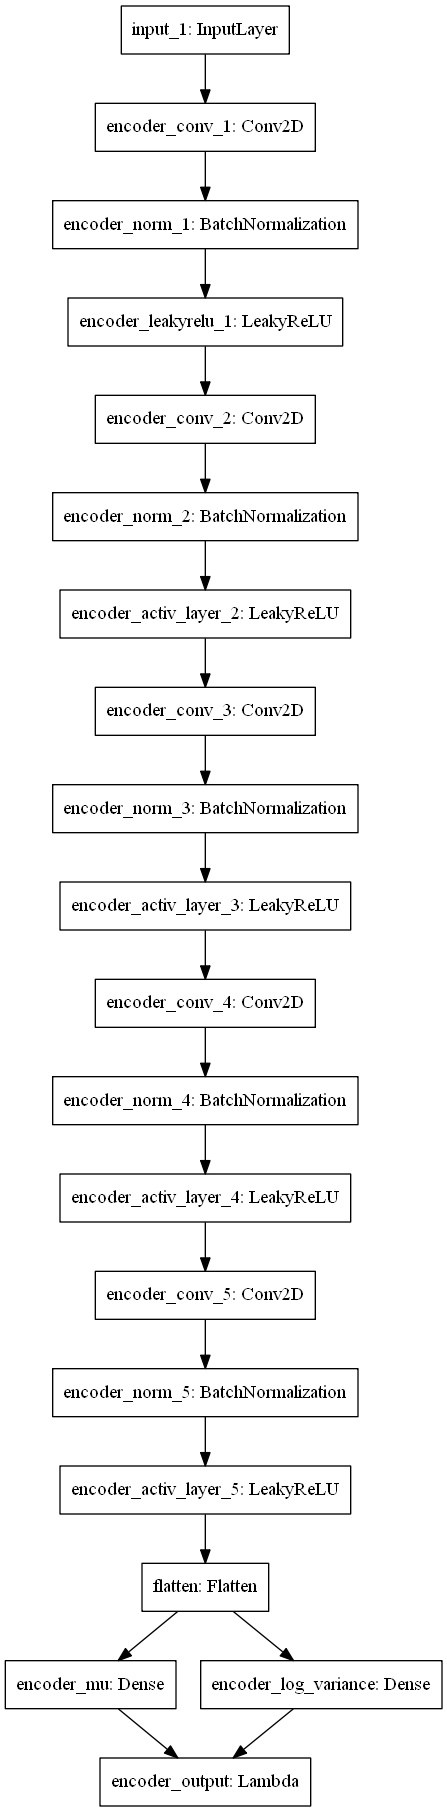

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder.png')

# Implementation of Decoder.

# デコーダの実装。

In [10]:
decoder_input = Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decoder = Model(decoder_input, decoder_output, name="decoder_model")

In [11]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 4)]               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 65536)             327680    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 32, 32, 64)        36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 32, 32, 64)        256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 32, 32, 64)        0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 64, 64, 64)      

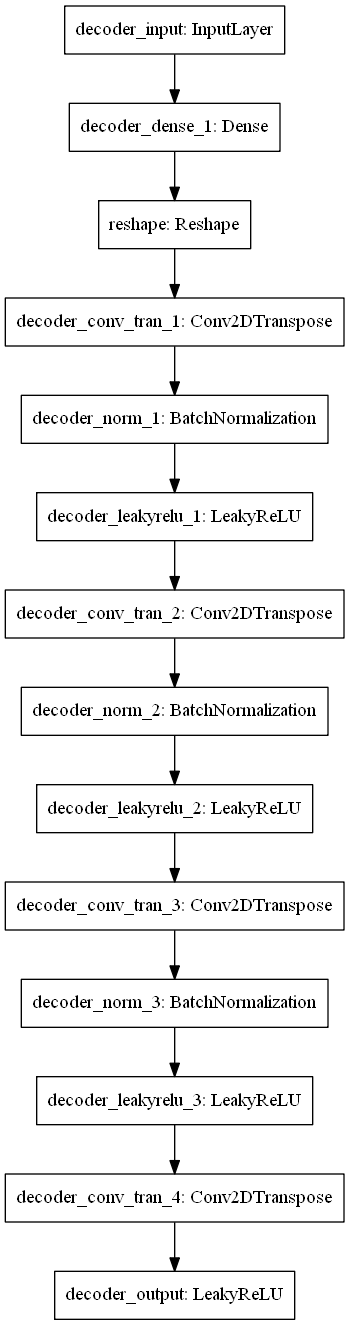

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(decoder, to_file='decoder.png')

# Implementation of VAE.

# VAEの実装。

In [12]:
vae_input = Input(shape=img_size + (3,))
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name="VAE")

In [13]:
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_model (Functional)   (None, 4)                 617896    
_________________________________________________________________
decoder_model (Functional)   (None, 128, 128, 1)       439809    
Total params: 1,057,705
Trainable params: 1,056,871
Non-trainable params: 834
_________________________________________________________________


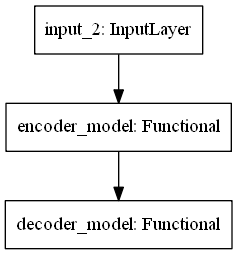

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(vae, to_file='VAE.png')

# Implementation of Loss Function.

# 損失関数の実装。

In [15]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

# Instantiate Data Sequences .

# データシーケンスのインスタンス化 。

In [16]:
# Instantiate data Sequences for each split
train_gen = Washer(batch_size, img_size, train_path)
val_gen = Washer(batch_size, img_size, valid_path)
test_gen = Washer(batch_size, img_size, test_path)

# Train VAE  Model.

# VAEモデルの学習。

In [17]:
# Configure the model for training.

vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001), loss=loss_func(encoder_mu, encoder_log_variance))

callbacks = [
    keras.callbacks.ModelCheckpoint("washer_segmentation_VAE.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
vae.fit(train_gen, epochs=epochs,validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - 4s 121ms/step - loss: 17726034.0000 - val_loss: 15567176.0000
Epoch 2/30
30/30 [==============================] - 3s 105ms/step - loss: 17347950.0000 - val_loss: 15553448.0000
Epoch 3/30
30/30 [==============================] - 3s 105ms/step - loss: 17008502.0000 - val_loss: 15523744.0000
Epoch 4/30
30/30 [==============================] - 3s 108ms/step - loss: 16789678.0000 - val_loss: 15485982.0000
Epoch 5/30
30/30 [==============================] - 3s 106ms/step - loss: 16650500.0000 - val_loss: 15396530.0000
Epoch 6/30
30/30 [==============================] - 3s 102ms/step - loss: 16497581.0000 - val_loss: 15247856.0000
Epoch 7/30
30/30 [==============================] - 3s 104ms/step - loss: 16442853.0000 - val_loss: 15090011.0000
Epoch 8/30
30/30 [==============================] - 3s 105ms/step - loss: 16432154.0000 - val_loss: 14896915.0000
Epoch 9/30
30/30 [==============================] - 3s 112ms/step - loss: 16427595.0000 

# Loss and Validation Loss Curve.

# 損失とバリデーションの損失曲線.

<AxesSubplot:>

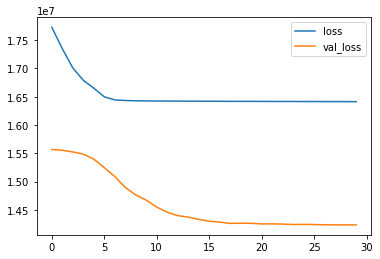

In [18]:
import pandas as pd
model_loss = pd.DataFrame(vae.history.history)
model_loss.plot()

# Predictions for Images in Test Data Set.

# テストデータセットに含まれる画像の予測値です。

In [19]:
# Generate predictions for all images in the test set
test_gen = Washer(1, img_size, test_path)
test_preds = vae.predict(test_gen)

# Inference Test Data with Heat Map.

# ヒートマップによる推論テストデータ。

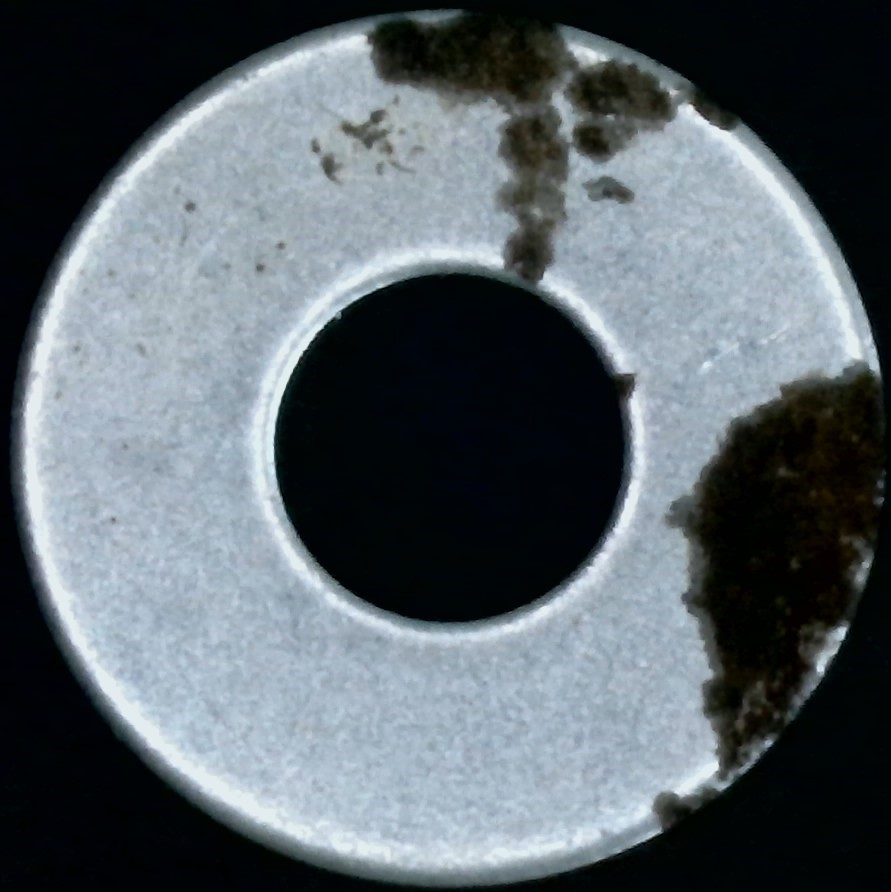

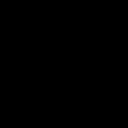

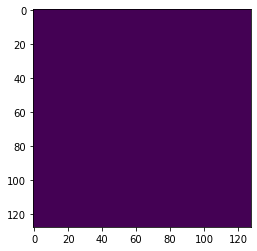

In [20]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    plt.imshow(mask)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for test image 
i = 1

# Display input image
display(Image(filename=test_path[i], width=256, height=256))


# Display mask predicted by our model
display_mask(i)  